In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import random
import numpy as np
from scipy.misc import imresize
import matplotlib.pyplot as plt

%matplotlib inline
import pickle

## 1. Load and reformat the data

In [2]:
data = input_data.read_data_sets("../data/MNIST/", one_hot=False)

Extracting ../data/MNIST/train-images-idx3-ubyte.gz
Extracting ../data/MNIST/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
train_dataset, train_labels = data.train.images.reshape((-1, 28, 28, 1)), data.train.labels.astype(np.int32)
valid_dataset, valid_labels = data.validation.images.reshape((-1, 28, 28, 1)), data.validation.labels.astype(np.int32)
test_dataset, test_labels = data.test.images.reshape((-1, 28, 28, 1)), data.test.labels.astype(np.int32)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (55000, 28, 28, 1), (55000,))
('Validation set', (5000, 28, 28, 1), (5000,))
('Test set', (10000, 28, 28, 1), (10000,))


## 2. Create sequences

- The data should be a bit dirty: sequences in different places and have different sizes

- image size is 48 x 48


In [4]:
IMAGE_SIZE = 48
NUM_CHANNELS = 1
NUM_LABELS = 11 # 0-9 and no digit
N = 5 # max number of digits on the sequence

np.random.seed(0)
  
def create_sequences(images, labels):
     
    permutation = np.random.permutation(labels.shape[0])
    images, labels = images[permutation,:,:], labels[permutation]
    length = images.shape[0]
    index = 0
    seq_images = np.ndarray([length,IMAGE_SIZE,IMAGE_SIZE,NUM_CHANNELS], dtype='float32')
    seq_labels = np.ones([length, N+1], dtype=int) * 10 # init to 10 cause it would be no digit, including L
  
    while index < length:
        L = random.randint(1, N) 
        offset = random.randint(0, length-N)
        selected = images[offset:offset+L,:,:,:] ## images are randomly shuffled
        sequence = np.hstack(selected) #28x28*Lx1
        sequence = sequence.reshape(sequence.shape[0], sequence.shape[1],).astype(np.float32)
        
        #scale = float(seq_images.shape[1]) / (L * 28)
        #
        ### add some randomness in scaling strategy:
        #if random.randint(1,100)>50:
        #    sequence = imresize(sequence, scale, interp='bilinear')
        #else:
        #    sequence = imresize(sequence, (IMAGE_SIZE,IMAGE_SIZE))
        #       
        #max_top = seq_images.shape[1] - sequence.shape[0] 
        #max_left = seq_images.shape[2] - sequence.shape[1]      
        #
        #top = np.random.randint(0,max_top) if max_top > 0 else 0
        #left = np.random.randint(0,max_left) if max_left > 0 else 0
        #       
        #seq_images[index,top:top+sequence.shape[0],left:left+sequence.shape[1],0] = sequence
        
        sequence = imresize(sequence, (IMAGE_SIZE,IMAGE_SIZE))
        sequence = sequence.reshape((IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)).astype(np.float32)
        seq_images[index] = sequence
        seq_labels[index, 0] = L

        for local_index in range(1,L+1): # including L too (labels)
            seq_labels[index, local_index] = labels[offset+local_index-1]
        index += 1

    return seq_images, seq_labels

In [5]:
train_dataset, train_labels = create_sequences(train_dataset, train_labels)
test_dataset, test_labels = create_sequences(test_dataset, test_labels)
valid_dataset, valid_labels = create_sequences(valid_dataset, valid_labels)


print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (55000, 48, 48, 1), (55000, 6))
('Validation set', (5000, 48, 48, 1), (5000, 6))
('Test set', (10000, 48, 48, 1), (10000, 6))


## 3. Take a look at generated examples

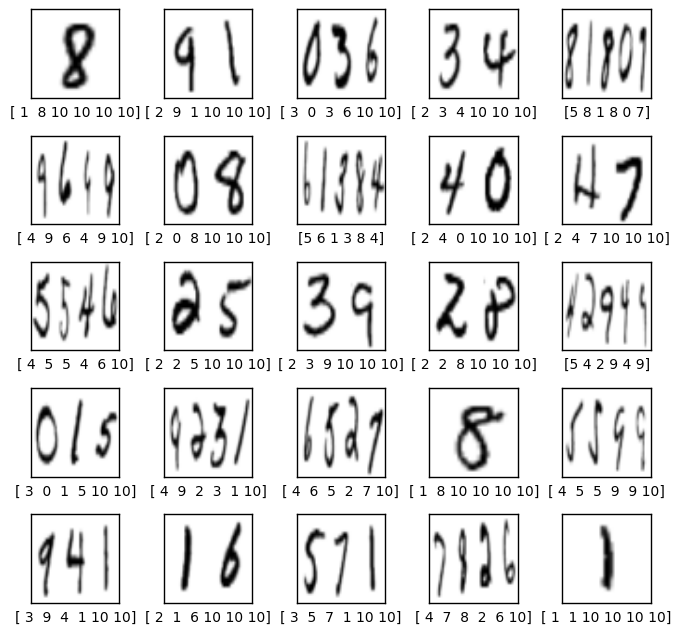

In [11]:
rand_list = random.sample(range(1, train_dataset.shape[0]), 25)
images = train_dataset[rand_list,:,:,:]

fig, axes = plt.subplots(5,5,figsize=(8, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.5)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='binary')
    ax.set_xticks([])
    ax.set_yticks([])
    xlabel=train_labels[rand_list[i]]
    ax.set_xlabel(xlabel)
    
plt.savefig('../images/mnist_sequence.png')

## 4. Pickle

In [25]:
mnist_seq = dict()
mnist_seq["train_dataset"] = train_dataset
mnist_seq["train_labels"]  = train_labels
mnist_seq["test_dataset"]  = test_dataset
mnist_seq["test_labels"]   = test_labels
mnist_seq["valid_dataset"] = valid_dataset
mnist_seq["valid_labels"]  = valid_labels

In [26]:
fileObject = open('../pickles/mnist_seq','wb') 
pickle.dump(mnist_seq,fileObject)   
fileObject.close()